In [301]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [302]:
data = pd.read_csv(r"C:\Users\Asus-PC12\Desktop\incl.csv", index_col=False)

In [303]:
data.head()

,depth,inclination,azimuth
0,0,0,0
1,30,0,0
2,60,1,10
3,90,3,15
4,120,3,20


In [304]:
data['cos(incl)'] = np.cos(data['inclination'] * np.pi/180)
data['sin(incl)'] = np.sin(data['inclination'] * np.pi/180)
data['cos(az)'] = np.cos(data['azimuth'] * np.pi/180)
data['sin(az)'] = np.sin(data['azimuth'] * np.pi/180)

In [305]:
# data['delta_depth'] = data['depth'] * data['cos(incl)']

In [306]:
data['delta_depth'] = ((data['depth'] - data['depth'].shift(1)).fillna(0)) * data['cos(incl)']
# data.head()

In [2105]:
data['TVD'] = data['delta_depth'].cumsum()

In [308]:
# North = MD * sin(i) * cos(az)
# East = MD * sin(i) * sin(az)
# TVD = MD * cos(i)

In [309]:
data['North'] = data['TVD'] * data['sin(incl)'] * data['cos(az)']
data['East'] = data['TVD'] * data['sin(incl)'] * data['sin(az)']

In [310]:
# data.head()
data['North_max'] = data['North'].max()
data['East_min'] = data['East'].min()
data['TVD_max'] = data['TVD'].max()

In [311]:
# z = data['depth']
z = data['TVD']
# y = data['inclination']
# x = data['azimuth']
x = data['East']
y = data['North']
x1 = data['North_max']
y1 = data['East_min']
z1 = data['TVD_max']

In [312]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

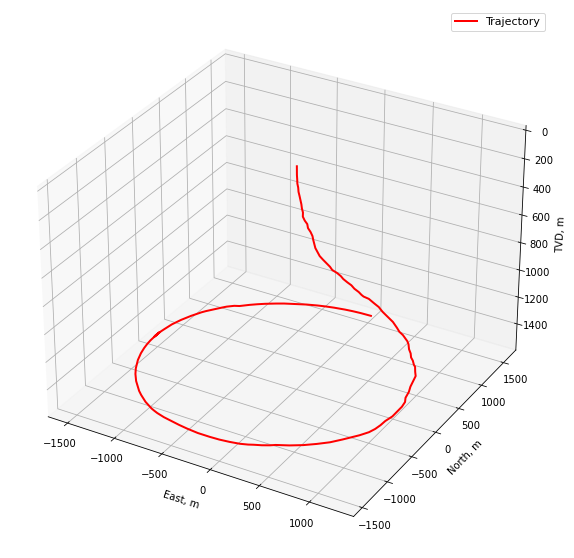

In [313]:
mpl.rcParams['legend.fontsize'] = 11

fig = plt.figure(figsize=(16,10))
ax = fig.gca(projection='3d')
ax.plot(x, y, z, label='Trajectory', color='red', lw=2)
ax.set_xlabel('East, m')
ax.set_ylabel('North, m')
ax.set_zlabel('TVD, m')
ax.invert_zaxis()
# ax.invert_xaxis()
# ax.invert_yaxis()
ax.legend()

plt.show()

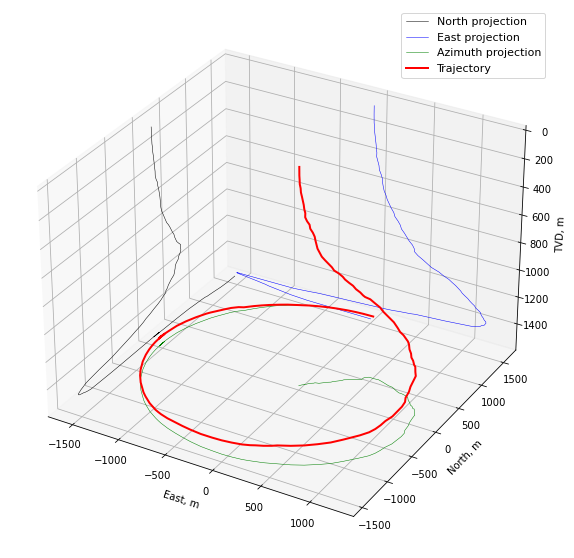

In [766]:
mpl.rcParams['legend.fontsize'] = 11

fig = plt.figure(figsize=(16,10))
ax = fig.gca(projection='3d')
ax.plot(-x1, y, z, label='North projection', color='black', lw=0.5)
ax.plot(x, -y1, z, label='East projection',color='blue', lw=0.5)
ax.plot(x, y, z1, label='Azimuth projection',color='green', lw=0.5)
ax.plot(x, y, z, label='Trajectory', color='red', lw=2)
ax.set_xlabel('East, m')
ax.set_ylabel('North, m')
ax.set_zlabel('TVD, m')
ax.invert_zaxis()
# ax.invert_xaxis()
# ax.invert_yaxis()
ax.legend()

plt.show()


In [767]:
# data.head(), data.shape

In [768]:
# VME
# axial load, thread connection, pipe body
# RIH / POOH loads
# friction
# bending, balooning, outer/inner pressures effects
# temperature effects (elongation => force), distributed temperature
# packer loads

In [1983]:
specific_weight = 15.2 # kg/m
wt = 7.34 # mm
OD = 88.9 # mm
ID = OD - 2 * wt
A = 0.785 * (OD**2 - (OD - 2 * wt)**2) / 1000000 # m2
rho = 1.10 # sg, g/sm3
g = 9.81 # m/s2
E = 206.7e9 # Pa
grade = 80 # ksi
SF = 1. # safety factor
Tol = 0.875 # wall thikness tolerance (12.5% reduction), for CRA pipe 0.9 (10% reduction)
# Buoyoancy factor = 1 - (fluid density / steel density)
# steel density 7842 kg/m3
D_t = OD / wt

In [1984]:
bf = round(1 - rho / 7.842, 3)
bf

0.86

In [1985]:
h = data['TVD'].max()

In [1986]:
P = g * rho * 1000 * h 
F = P * A / 9.81

In [1987]:
Loads = pd.DataFrame(data['TVD']*specific_weight)

In [1988]:
Loads['Weight_in_Fluid'] = data['TVD'] * bf * specific_weight
# Loads.head()

In [1989]:
Loads.rename(columns={'TVD':'Weight_on_Air'})
Loads['TVD'] = data['TVD']
Loads['Weight_on_Air'] = Loads['TVD'] * specific_weight
# Loads.head()

In [1990]:
Loads['W_i_F'] = Loads['Weight_on_Air'] - F

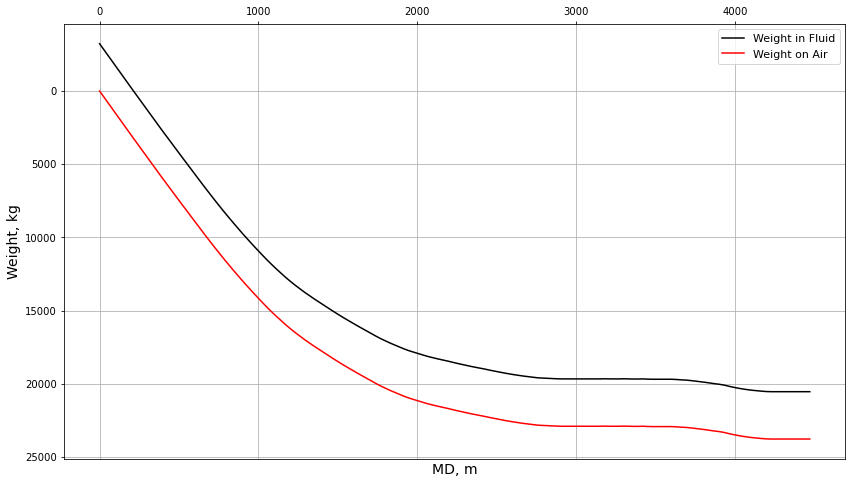

In [1991]:
plt.figure(figsize=(14,8))

plt.plot(data['depth'], Loads['W_i_F'], color='k', label='Weight in Fluid')
plt.plot(data['depth'], Loads['Weight_on_Air'], color='red', label='Weight on Air')
# plt.plot(data['depth'], Loads['Weight_in_Fluid'],color='blue')

plt.ylabel('Weight, kg', fontsize=14)
plt.xlabel('MD, m', fontsize=14)
plt.legend()
plt.gca().xaxis.tick_top()
plt.gca().invert_yaxis()

plt.grid()
plt.show()

In [1992]:
friction_factor_1 = 0.3
friction_factor_2 = 0.2

In [1993]:
Loads['Outstep'] = data['depth'] * data['sin(incl)']

In [1994]:
Loads['Pull_0.3'] = Loads['W_i_F'] + Loads['Outstep'] * friction_factor_1 * specific_weight
Loads['Pull_0.2'] = Loads['W_i_F'] + Loads['Outstep'] * friction_factor_2 * specific_weight
Loads['RIH_0.3'] = Loads['W_i_F'] - Loads['Outstep'] * friction_factor_1 * specific_weight
Loads['RIH_0.2'] = Loads['W_i_F'] - Loads['Outstep'] * friction_factor_2 * specific_weight

In [1995]:
# plt.figure(figsize=(14,8))

# plt.plot(Loads['Pull_0.3'], data['depth'], color='red', label='Pull_0.3')
# plt.plot(Loads['RIH_0.3'], data['depth'], color='blue', label='RIH_0.3')

# plt.plot(Loads['Pull_0.2'], data['depth'], color='green', label='Pull_0.2')
# plt.plot(Loads['RIH_0.2'], data['depth'], color='k', label='RIH_0.2')

# plt.plot(Loads['W_i_F'], data['depth'], color='y', label='Weight_in_Fluid')
# # plt.plot(Loads['Weight_in_Fluid'], data['depth'], color='y', label='Weight_in_Fluid')

# plt.legend()
# plt.xlabel('Weight, kg', fontsize=14, labelpad=15)
# plt.ylabel('MD, m', fontsize=14)

# plt.gca().xaxis.tick_top()
# plt.gca().xaxis.set_label_position('top')
# plt.gca().invert_yaxis()

# plt.grid()
# plt.show()

In [1996]:
# plt.figure(figsize=(14,8))

# plt.plot(Loads['Pull_0.3'], Loads['TVD'], color='red', label='Pull_0.3')
# plt.plot(Loads['RIH_0.3'], Loads['TVD'], color='blue', label='RIH_0.3')

# plt.plot(Loads['Pull_0.2'], Loads['TVD'], color='green', label='Pull_0.2')
# plt.plot(Loads['RIH_0.2'], Loads['TVD'], color='k', label='RIH_0.2')

# plt.plot(Loads['W_i_F'], Loads['TVD'], color='y', label='Weight_in_Fluid')

# plt.legend()
# plt.xlabel('Weight, kg', fontsize=14, labelpad=15)
# plt.ylabel('TVD, m', fontsize=14)

# plt.gca().xaxis.tick_top()
# plt.gca().xaxis.set_label_position('top')
# plt.gca().invert_yaxis()

# plt.grid()
# plt.show()

In [1997]:
Loads['revRIH_0.3'] = Loads['RIH_0.3'].values[::-1]
Loads['revPull_0.3'] = Loads['Pull_0.3'].values[::-1]
Loads['revRIH_0.2'] = Loads['RIH_0.2'].values[::-1]
Loads['revPull_0.2'] = Loads['Pull_0.2'].values[::-1]
Loads['revW_i_F'] = Loads['W_i_F'].values[::-1]
Loads['revW_on_A'] = Loads['Weight_on_Air'].values[::-1]
# Loads.head()

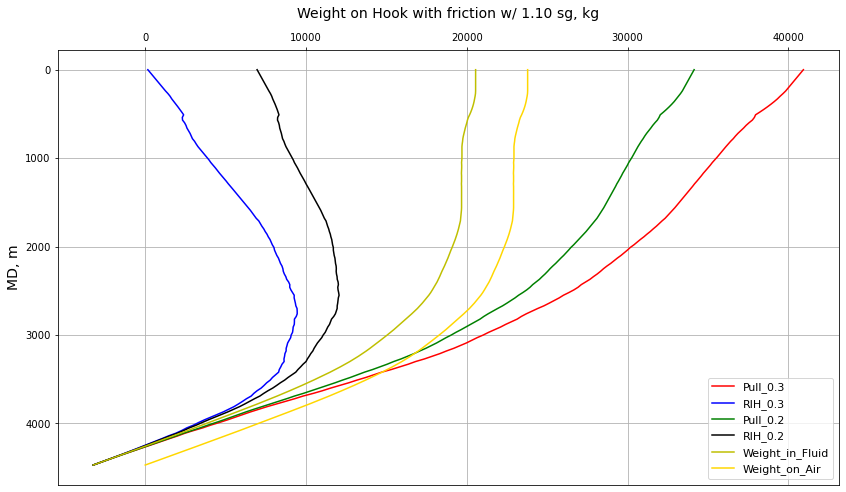

In [1998]:
plt.figure(figsize=(14,8))

plt.plot(Loads['revPull_0.3'], data['depth'], color='red', label='Pull_0.3')
plt.plot(Loads['revRIH_0.3'], data['depth'], color='blue', label='RIH_0.3')

plt.plot(Loads['revPull_0.2'], data['depth'], color='green', label='Pull_0.2')
plt.plot(Loads['revRIH_0.2'], data['depth'], color='k', label='RIH_0.2')

plt.plot(Loads['revW_i_F'], data['depth'], color='y', label='Weight_in_Fluid')
plt.plot(Loads['revW_on_A'], data['depth'], color='gold', label='Weight_on_Air')

plt.legend()
plt.xlabel('Weight on Hook with friction w/ 1.10 sg, kg', fontsize=14, labelpad=15)
plt.ylabel('MD, m', fontsize=14)

plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.gca().invert_yaxis()

plt.grid()
plt.show()

In [1999]:
Loads['DLS'] = data['inclination'] - data['inclination'].shift(1).fillna(0)
# Loads.head()

In [2000]:
# +/- sigma = +/- (E * D) / (2 R) = (E * D)/ [(2 * 360 *  delta_L)/(2 * pi * DLS )]
Loads['sigma'] = (E * OD/1000) / (360 * 30)/np.pi * Loads['DLS']
# Loads['sigma'].head()

In [2001]:
Loads['Bend'] = Loads['sigma'] * A
Loads['revBend'] = Loads['Bend'].values[::-1]

In [2002]:
# with bending
Loads['W_i_F_Bend_+'] = Loads['W_i_F'] + Loads['Bend']
Loads['W_i_F_Bend_-'] = Loads['W_i_F'] - Loads['Bend']

Loads['revW_i_F_Bend_+'] = Loads['W_i_F_Bend_+'].values[::-1]
Loads['revW_i_F_Bend_-'] = Loads['W_i_F_Bend_-'].values[::-1]

Loads['revRIH_0.3_B+'] = Loads['revRIH_0.3'] + Loads['revBend']
Loads['revRIH_0.3_B-'] = Loads['revRIH_0.3'] - Loads['revBend']

Loads['revPull_0.3_B+'] = Loads['revPull_0.3'] + Loads['revBend']
Loads['revPull_0.3_B-'] = Loads['revPull_0.3'] - Loads['revBend']

Loads['revRIH_0.2_B+'] = Loads['revRIH_0.2'] + Loads['revBend']
Loads['revRIH_0.2_B-'] = Loads['revRIH_0.2'] - Loads['revBend']

Loads['revPull_0.2_B+'] = Loads['revPull_0.2'] + Loads['revBend']
Loads['revPull_0.2_B-'] = Loads['revPull_0.2'] - Loads['revBend']

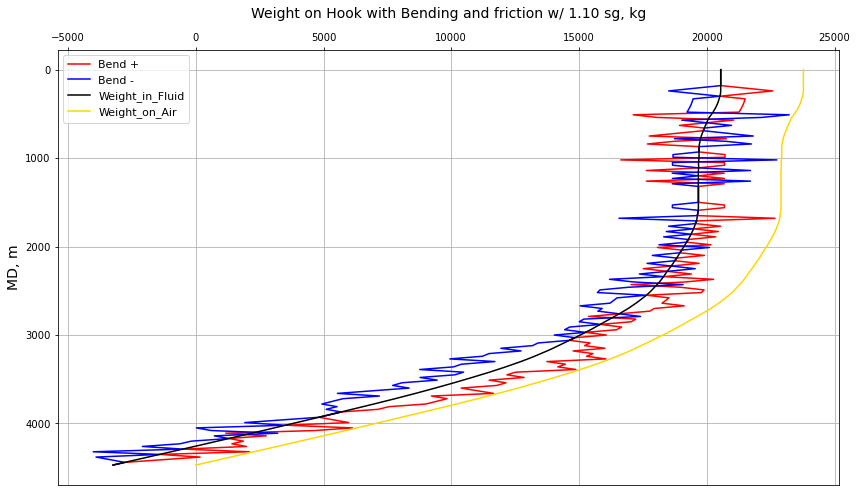

In [2003]:
plt.figure(figsize=(14,8))

plt.plot(Loads['revW_i_F_Bend_+'], data['depth'], color='red', label='Bend +')
plt.plot(Loads['revW_i_F_Bend_-'], data['depth'], color='blue', label='Bend -')

plt.plot(Loads['revW_i_F'], data['depth'], color='k', label='Weight_in_Fluid')
plt.plot(Loads['revW_on_A'], data['depth'], color='gold', label='Weight_on_Air')

plt.legend()
plt.xlabel('Weight on Hook with Bending and friction w/ 1.10 sg, kg', fontsize=14, labelpad=15)
plt.ylabel('MD, m', fontsize=14)

plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.gca().invert_yaxis()

plt.grid()
plt.show()

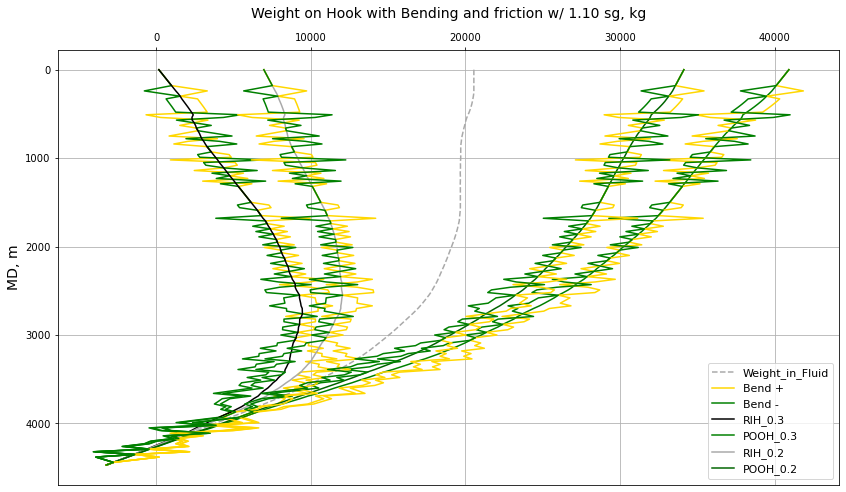

In [2004]:
plt.figure(figsize=(14,8))

plt.plot(Loads['revW_i_F'], data['depth'], color='darkgrey', ls='--', label='Weight_in_Fluid')

plt.plot(Loads['revRIH_0.3_B+'], data['depth'], color='gold',)# label='Bend +')
plt.plot(Loads['revRIH_0.3_B-'], data['depth'], color='g',)# label='Bend -')

plt.plot(Loads['revRIH_0.3'], data['depth'], color='k',)# label='RIH_0.3')
plt.plot(Loads['revPull_0.3'], data['depth'], color='green',)# label='POOH_0.3')

plt.plot(Loads['revRIH_0.2'], data['depth'], color='darkgrey',)# label='RIH_0.2')
plt.plot(Loads['revPull_0.2'], data['depth'], color='darkgreen',)# label='POOH_0.2')

plt.plot(Loads['revPull_0.3_B+'], data['depth'], color='gold',)# label='Bend +')
plt.plot(Loads['revPull_0.3_B-'], data['depth'], color='g',)# label='Bend -')

plt.plot(Loads['revRIH_0.2_B+'], data['depth'], color='gold',)# label='Bend +')
plt.plot(Loads['revRIH_0.2_B-'], data['depth'], color='g',)# label='Bend -')

plt.plot(Loads['revPull_0.2_B+'], data['depth'], color='gold',)# label='Bend +')
plt.plot(Loads['revPull_0.2_B-'], data['depth'], color='g',)# label='Bend -')

plt.legend(['Weight_in_Fluid', 'Bend +', 'Bend -', 'RIH_0.3', 'POOH_0.3','RIH_0.2','POOH_0.2' ])
plt.xlabel('Weight on Hook with Bending and friction w/ 1.10 sg, kg', fontsize=14, labelpad=15)
plt.ylabel('MD, m', fontsize=14)

plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.gca().invert_yaxis()

plt.grid()
plt.show()

In [2005]:
# ksi -> MPa * 6.895
grade_MPa = round(grade * 6.895, 3)
# force = MPa * Area
force = round(grade_MPa * A * 10**6, 3) # N
# weight = force / g
weight_t = round(force / g / 1000, 3) # t
grade_MPa, force, weight_t

(551.6, 1036876.86, 105.696)

API Burst (Barlow's formula)

In [2006]:
P_burst = round(Tol * 2 * grade * 1000 / D_t/SF)
P_burst

11559

DLP in ksi

In [2007]:
Grade_plus_burst = grade + P_burst

In [2008]:
# from math import pi, cos, sin
# from matplotlib.patches import Rectangle

# u=0.       #x-position of the center
# v=0.      #y-position of the center
# a= (grade * 2 ** 0.5 )/ SF      #radius on the x-axis
# b= (grade * (2 / 3) ** 0.5 )/ SF     #radius on the y-axis
# t_rot=pi/4 #rotation angle


# t = np.linspace(0, 2*pi, 100)
# # t = np.linspace(-pi/4, 3*pi/4, 100)
# Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
#      #u,v removed to keep the same center location
# R_rot = np.array([[cos(t_rot) , -sin(t_rot)],[sin(t_rot) , cos(t_rot)]])  
#      #2-D rotation matrix

# Ell_rot = np.zeros((2,Ell.shape[1]))

# for i in range(Ell.shape[1]):
#     Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])

# x_left = -(Grade_plus_burst)* 1.2
# y_bottom = - (Grade_plus_burst) * 1.2
# x_right = (Grade_plus_burst) * 1.2
# y_top = (Grade_plus_burst) * 1.2

# plt.figure(figsize=(12,10))
# # plt.plot( u+Ell[0,:] , v+Ell[1,:] )     #initial ellipse

# plt.plot( u+Ell_rot[0,:] , v+Ell_rot[1,:],'r' )    #rotated ellipse

# # axis spines
# ax = plt.gca()
# ax.set_xlim(x_left, x_right)
# ax.set_ylim(y_bottom, y_top)
# ax.spines['left'].set_position('center')
# ax.spines['bottom'].set_position('center')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# # frame
# ax.add_patch(Rectangle((x_left, y_bottom + 1), x_right * 2-1 , y_top * 2 - 1  ,
#              edgecolor = 'k',
#              fill=False,
#              lw=0.5))


# plt.title(f'VME for grade {grade} and safety factor {SF}', fontsize=15)

# plt.text(-Grade_plus_burst/12 , Grade_plus_burst*1.15, 'Burst', fontsize=15)
# plt.text(-Grade_plus_burst/8, -Grade_plus_burst*1.18, 'Collapse', fontsize=15)
# plt.text(Grade_plus_burst*1.15, -Grade_plus_burst/10,  'Tension', rotation=90, fontsize=15)
# plt.text(-Grade_plus_burst*1.18, -Grade_plus_burst/5, 'Compression', rotation=90, fontsize=15)
    

# plt.xlabel('ksi     ', loc='right', fontsize=15,)
# plt.ylabel('ksi    ', loc='top', fontsize=15)
           
# plt.grid(color='lightgray',linestyle='--', )
# plt.show()

DLP in MPa and t

In [2009]:
# from math import pi, cos, sin
# from matplotlib.patches import Rectangle

# u=0.       #x-position of the center
# v=0.      #y-position of the center
# a= grade_MPa * 2 ** 0.5 / SF      #radius on the x-axis
# b= grade_MPa * (2 / 3) ** 0.5 / SF     #radius on the y-axis
# t_rot=pi/4 #rotation angle

# t = np.linspace(0, 2*pi, 100)
# Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
#      #u,v removed to keep the same center location
# R_rot = np.array([[cos(t_rot) , -sin(t_rot)],[sin(t_rot) , cos(t_rot)]])  
#      #2-D rotation matrix

# Ell_rot = np.zeros((2,Ell.shape[1]))
# for i in range(Ell.shape[1]):
#     Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])

# x_left = -grade_MPa * 1.2
# y_bottom = - grade_MPa * 1.2
# x_right = grade_MPa * 1.2
# y_top = grade_MPa * 1.2

# plt.figure(figsize=(12,10))
# # plt.plot( u+Ell[0,:] , v+Ell[1,:] )     #initial ellipse

# plt.plot( u+Ell_rot[0,:] , v+Ell_rot[1,:],'r' )    #rotated ellipse

# # axis spines
# ax = plt.gca()
# ax.set_xlim(x_left, x_right)
# ax.set_ylim(y_bottom, y_top)
# ax.spines['left'].set_position('center')
# ax.spines['bottom'].set_position('center')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# # frame
# ax.add_patch(Rectangle((x_left, y_bottom + 1), x_right * 2-1 , y_top * 2 - 1  ,
#              edgecolor = 'k',
#              fill=False,
#              lw=0.5))


# plt.title(f'VME for grade {grade} and safety factor {SF}', fontsize=15)

# plt.text(-grade_MPa/12 , grade_MPa*1.15, 'Burst', fontsize=15)
# plt.text(-grade_MPa/8, -grade_MPa*1.18, 'Collapse', fontsize=15)
# plt.text(grade_MPa*1.15, -grade_MPa/10,  'Tension', rotation=90, fontsize=15)
# plt.text(-grade_MPa*1.18, -grade_MPa/5, 'Compression', rotation=90, fontsize=15)

# X_str=[]
# for i in np.linspace(-weight_t,  weight_t, 7):
#     X_str.append(str(i))
# plt.xticks(ticks=np.linspace(-grade_MPa, grade_MPa, 7),labels=X_str)
# plt.xlabel('t     ', loc='right', fontsize=15,)
# plt.ylabel('MPa    ', loc='top', fontsize=15)
           
# plt.grid(color='lightgray',linestyle='--', )
# plt.show()



In [2010]:
#  z = -np.linspace(9,15,100)
# x = np.linspace(-26,26,1000) 
# x,z = np.meshgrid(x,z) 
# Z = -np.exp(-0.05*z) +4*(z+10)**2 
# X = x**2 
# plt.contour(x,z,(X+Z),[0]) 
# plt.xlim([-1.5,1.5]) 
# plt.ylim([-11.5,-8.5])
# plt.grid(linestyle='dotted')
# plt.show()

In [2011]:
# x = np.arange(-5, 5, 0.1)
# y = np.arange(-5, 5, 0.1)
# xx, yy = np.meshgrid(x, y, sparse=True)
# z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
# h = plt.contourf(x,y,z)
# plt.show()

In [2012]:
# x, y, z = map(int, input().strip().split())
# print(f"Volume is {x * y * z}")
# print(f'x = {x}')
# print(f'y = {y}')
# print(f'z = {z}')

In [2013]:
# from matplotlib.patches import Ellipse
# import matplotlib as mpl
# %matplotlib inline
# from matplotlib import pyplot as plt

# mean = [1, 1]
# width = 100
# height = 200
# angle = 45
# ell = mpl.patches.Ellipse(xy=mean, width=width, height=height, angle = 180+angle)
# fig, ax = plt.subplots()
# ax.add_artist(ell)

# ax.set_aspect('equal')
# ax.set_xlim(-150, 150)
# ax.set_ylim(-150, 150)
# plt.grid(linestyle='dotted')
# plt.show()

In [2014]:
# # mean = [ 19.92977907 ,  5.07380955]
# mean = [0, 0]
# width = grade * 2 ** 0.5
# height = grade * (2 / 3) ** 0.5
# angle = 45

# ell = mpl.patches.Ellipse(xy=mean, width=width, 
#                           height=height, angle = 180+angle, 
#                           color='red', lw=2, #fc='lightgrey'
#                          fill=False
#                          )
# fig, ax = plt.subplots()

# ax.add_patch(ell)
# # ax.set_aspect('equal')
# ax.autoscale()

# plt.grid(ls='dotted')
# plt.show()

In [2015]:
axial_stress = round(10.2 * bf * (data['TVD'].max() / 0.3048) / (0.785 *(3.5**2 - 2.922**2)))  
axial_stress

15452

In [2016]:
P_i = 1
P_o = 1
ax = ((axial_stress + P_i)/ grade / 1000) # correction for grade according to 2018 version of the API 5C3
ax

0.1931625

In [2017]:
grade_ = round(grade  * ((1 - 0.75 * (ax)**2)**0.5 - 0.5*(ax)))
grade_

71

Yield collapse:
The formula used for determination of yield strength collapse was derived from the theoretical von Mises maximum distortion energy theory for yielding. This means that pipe failing due to yield will be limited to the von Mises ellipsis

Elastic collapse is not affected by axial stress, these pipes would be limited to the horizontal line 

Plastic and Transition collapse: reduction from the uniaxial value see above, which is limited to tension only. I.e. quadrant four
 

Yield collapse

In [2018]:
P_yield = round(2 * grade_ * 1000 *( D_t - 1) / D_t ** 2 / SF)
P_yield

10756

Elastic collapse

In [2019]:
P_elastic = round(46.95e6 / (D_t * (D_t - 1)**2) / SF)
P_elastic

31396

Collapse factors
A, B, C - for plastic, F, G - for transitional

In [2020]:
collapse_factor = {'40':[2.95, 0.0465, 754, 2.063, 0.0325, 16.40, 27.01, 42.64, '<'], 
                   '50':[2.976, 0.0515, 1056, 2.003, 0.0347, 15.24, 25.63, 38.83, '<'],
                   '55':[2.991, 0.0541, 1206, 1.989, 0.0360, 14.81, 25.01, 37.21, '<'],
                   '60':[3.005, 0.0566, 1356, 1.983, 0.0373, 14.44, 24.42, 35.73, '<'],
                   '70':[3.037, 0.0617, 1656, 1.984, 0.0403, 13.85, 23.38, 33.17, '<'],
                   '75':[3.054, 0.0642, 1806, 1.990, 0.0418, 13.60, 22.91, 32.05, '<'],
                   '80':[3.071, 0.0667, 1955, 1.998, 0.0434, 13.38, 22.47, 31.02, '<'],
                   '90':[3.106, 0.0718, 2254, 2.017, 0.0466, 13.01, 21.69, 29.18, '<'],
                   '95':[3.124, 0.0743, 2404, 2.029, 0.0482, 12.85, 21.33, 28.36, '<'],
                   '100':[3.143, 0.0768, 2553, 2.040, 0.0499, 12.70, 21.00, 27.60, '<'],
                   '105':[3.162, 0.0794, 2702, 2.053, 0.0515, 12.57, 20.70, 26.89, '<'],
                   '110':[3.181, 0.0819, 2852, 2.066, 0.0532, 12.44, 20.41, 26.22, '<'],
                   '120':[3.219, 0.0870, 3151, 2.092, 0.0565, 12.21, 19.88, 25.01, '<'],
                   '125':[3.239, 0.0895, 3301, 2.106, 0.0582, 12.11, 19.63, 24.46, '<'],
                   '130':[3.258, 0.0920, 3451, 2.119, 0.0599, 12.02, 19.40, 23.94, '<'],
                   '135':[3.278, 0.0946, 3601, 2.133, 0.0615, 11.92, 19.18, 23.44, '<'],
                   '140':[3.297, 0.0971, 3751, 2.146, 0.0632, 11.84, 18.97, 22.98, '<'],
                   '150':[3.336, 0.1021, 4053, 2.174, 0.0666, 11.67, 18.57, 22.11, '<'],
                   '155':[3.356, 0.1047, 4204, 2.188, 0.0683, 11.59, 18.37, 21.70, '<'],
                  '160':[3.375, 0.1072, 4356, 2.202, 0.0700, 11.52, 18.19, 21.32, '<'],
                  '170':[3.412, 0.1123, 4660, 2.231, 0.0734, 11.37, 17.82, 20.60, '<'],
                  '180':[3.449, 0.1173, 4966, 2.261, 0.0769, 11.21, 17.47, 19.93, '<']}

collapse_factors = pd.DataFrame.from_dict(collapse_factor, 
                                         columns=['A', 'B', 'C', 'F', 'G', 
                                                  'D/t Yield max', ' D/t Plastic max', 
                                                  'D/t Trans max', 'D/t Elastic'],
                                         orient='index')
collapse_factors.at[f'{grade}', 'C']

1955

In [2021]:
collapse_factors.rename_axis('Grade', inplace=True)
collapse_factors

,A,B,C,F,G,D/t Yield max,D/t Plastic max,D/t Trans max,D/t Elastic
Grade,,,,,,,,,
40,2.950,0.0465,754,2.063,0.0325,16.40,27.01,42.64,<
50,2.976,0.0515,1056,2.003,0.0347,15.24,25.63,38.83,<
55,2.991,0.0541,1206,1.989,0.0360,14.81,25.01,37.21,<
60,3.005,0.0566,1356,1.983,0.0373,14.44,24.42,35.73,<
70,3.037,0.0617,1656,1.984,0.0403,13.85,23.38,33.17,<
75,3.054,0.0642,1806,1.990,0.0418,13.60,22.91,32.05,<
80,3.071,0.0667,1955,1.998,0.0434,13.38,22.47,31.02,<
90,3.106,0.0718,2254,2.017,0.0466,13.01,21.69,29.18,<
95,3.124,0.0743,2404,2.029,0.0482,12.85,21.33,28.36,<


Transitional collapse

In [2022]:
P_transitional = round(grade_ * 1000 * (collapse_factors.at[f'{grade}', 'F']/D_t - \
                                       collapse_factors.at[f'{grade}', 'G']) / SF)
P_transitional

8631

Plastic collapse

In [2023]:
P_plastic = round(grade_ * 1000* (collapse_factors.at[f'{grade}', 'A'] / \
                                 D_t - collapse_factors.at[f'{grade}', 'B']) - \
                  collapse_factors.at[f'{grade}', 'C'] / SF)

P_plastic

11312

In [2024]:
collapse_pressures = pd.DataFrame({'Collapse':['Yield', 'Plastic', 'Transitional', 'Elastic'],
                                   'Pressure, psi':[P_yield, P_plastic, P_transitional, P_elastic]},)
collapse_pressures

,Collapse,"Pressure, psi"
0,Yield,10756
1,Plastic,11312
2,Transitional,8631
3,Elastic,31396


ISO

Lower two quadrants (Pi = 0)

In [2115]:
ab = 1.0779 # correction for plot 1.0779
ac = 1.1546 # correction for plot 1.1546
D = 3.5
d = 2.922
pipe_Area = 0.785 * (D**2 - d**2)
t = (D - d) / 2
# axial_stress
f_y = grade * 1000 /SF

left_val = -f_y*ab
right_val = f_y*ac
step = 100

sigma_ai_1 = np.linspace(left_val, f_y, step) # bottom right
sigma_ai_2 = np.linspace(left_val, -f_y, step) # bottom left
sigma_ao_1 = np.linspace(-f_y,right_val, step) # top left
sigma_ao_2 = np.linspace(f_y, right_val, step) # top right


In [2098]:
K_po = 2 * D**2 / ( D**2 - d**2)
K_co_1 = sigma_ao_1**2 - f_y**2
K_bo_1 = - K_po * sigma_ao_1 # minus sign to rotate ellipse in correct position
K_co_2 = sigma_ao_2**2 - f_y**2
K_bo_2 = - K_po * sigma_ao_2 # minus sign to rotate ellipse in correct position
K_ao = K_po**2

In [2099]:
Po_plus = (-K_bo_1 + (K_bo_1**2 - 4 * K_ao * K_co_1)**0.5) / (2 * K_ao)/SF # top left
Po_minus = (-K_bo_2 - (K_bo_2**2 - 4 * K_ao * K_co_2)**0.5) / (2 * K_ao)/SF # top right

Upper two quadrants (Po = 0)

In [2100]:
K_pi = (D**2 + d**2) / (D**2 - d**2)
K_ci_1 = sigma_ai_1**2 - f_y**2
K_bi_1 = (1 - K_pi) * sigma_ai_1
K_ci_2 = sigma_ai_2**2 - f_y**2
K_bi_2 = (1 - K_pi) * sigma_ai_2
K_ai = K_pi**2 + K_pi + 1

In [2101]:
Pi_plus = (-K_bi_2 + (K_bi_2**2 - 4 * K_ai * K_ci_2)**0.5) / (2 * K_ai)/SF # bottom left
Pi_minus = (-K_bi_1 - (K_bi_1**2 - 4 * K_ai * K_ci_1)**0.5) / (2 * K_ai)/SF # bottom right

Collapse with Tension

In [2102]:
sigma_ct = np.linspace(0, f_y, int(step/2))

P_ct = -P_yield * ((1 - 0.75 * (sigma_ct / f_y)**2)**.5 - 0.5*(sigma_ct / f_y))

Initial condition

In [2138]:
data['TVD_feet'] = data['TVD'] / .3048
P_brine = data['TVD_feet'] * 0.433 * rho

Area_in = 0.785 * d**2
Area_out = 0.785 * D**2

P_in = 1
P_out = 1

In [2154]:
pipe_weight = 10.2 * data['TVD_feet'] * data['cos(incl)']
sigma_pipe = pipe_weight / pipe_Area - P_brine

delta_P = (P_in - P_out) + P_brine

Pressure Test

DLP

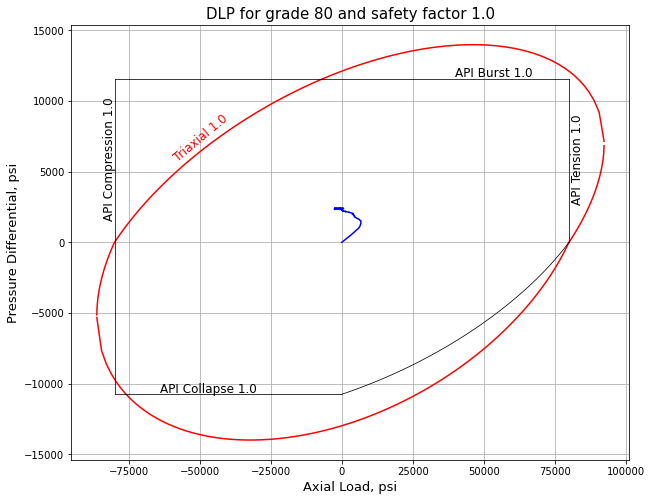

In [2155]:
plt.figure(figsize=(10,8))

plt.plot(sigma_ao_1, Po_plus, 'r')
plt.plot(sigma_ao_2, Po_minus, 'r')

plt.plot(sigma_ai_2, Pi_plus, 'r')
plt.plot(sigma_ai_1, Pi_minus, 'r')

plt.plot([-f_y, f_y], [P_burst, P_burst], 'k', lw=0.75) # Burst
plt.plot([f_y, f_y], [P_burst, 0],'k', lw=0.75) # Tension
plt.plot([-f_y, -f_y], [P_burst, -P_yield], 'k', lw=0.75) # Compression
plt.plot([-f_y, 0], [-P_yield, -P_yield], 'k', lw=0.75) # Collapse
plt.plot(sigma_ct, P_ct, 'k', lw=0.75) # Collapse and Tension

plt.plot(sigma_pipe, delta_P, 'b')

plt.text(0.5*f_y, P_burst+200, f'API Burst {SF}', fontsize=12, ) 
plt.text(f_y*1.01, P_burst*.25, f'API Tension {SF}', fontsize=12, rotation=90 ) 
plt.text(-f_y*1.05, P_burst*.15, f'API Compression {SF}', fontsize=12, rotation=90) 
plt.text(-0.8*f_y, -P_yield+100, f'API Collapse {SF}', fontsize=12, ) 
plt.text(-f_y*0.75, P_burst*.5, f'Triaxial {SF}', fontsize=12, rotation=40, color='r') 


plt.title(f'DLP for grade {grade} and safety factor {SF}', fontsize=15)

plt.xlabel('Axial Load, psi', fontsize=13)
plt.ylabel('Pressure Differential, psi', fontsize=13)


plt.grid()
plt.show()